In [41]:
import gymnasium as gym
import numpy as np

class DisturbedLunarLander(gym.Wrapper):
    def __init__(self, env, failure_prob=0.05, force_magnitude=10.0):
        super().__init__(env)
        self.failure_prob = failure_prob
        self.force_magnitude = force_magnitude

        # Unwrap to access the original LunarLander instance
        base = env
        while hasattr(base, "env"):
            base = base.env
        self.base_env = base  # This is now the actual LunarLander

    def step(self, action):
        # Random engine failure
        if np.random.rand() < self.failure_prob:
            action = 0  # Override with no-op

        obs, reward, terminated, truncated, info = self.env.step(action)

        # Random horizontal force
        if np.random.rand() < self.failure_prob:
            try:
                self.base_env.lander.ApplyForceToCenter(
                    (np.random.uniform(-self.force_magnitude, self.force_magnitude), 0),
                    True
                )
            except AttributeError:
                print("[Warning] lander not available at this step.")

        return obs, reward, terminated, truncated, info



In [37]:
class FuelAwareLunarLander(gym.Wrapper):
    def __init__(self, env, initial_fuel=100.0, fuel_costs=(0.3, 0.1, 0.1)):
        super().__init__(env)
        self.initial_fuel = initial_fuel
        self.fuel = initial_fuel
        self.fuel_costs = fuel_costs  # (main_engine, left_engine, right_engine)

        # Extend observation space by 1 (for fuel)
        low = np.append(self.observation_space.low, 0.0)
        high = np.append(self.observation_space.high, initial_fuel)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def reset(self, **kwargs):
        self.fuel = self.initial_fuel
        obs, info = self.env.reset(**kwargs)
        return np.append(obs, self.fuel), info

    def step(self, action):
        # Calculate fuel cost
        fuel_used = 0.0
        if action == 1:  # Main engine
            fuel_used = self.fuel_costs[0]
        elif action == 2:  # Left engine
            fuel_used = self.fuel_costs[1]
        elif action == 3:  # Right engine
            fuel_used = self.fuel_costs[2]

        # Reduce fuel
        self.fuel = max(self.fuel - fuel_used, 0.0)

        # Replace action with 0 if fuel is gone
        if self.fuel <= 0:
            action = 0

        obs, reward, terminated, truncated, info = self.env.step(action)

        # Add fuel penalty to reward (optional)
        reward -= fuel_used * 0.5  # Tune this factor

        # Append fuel to observation
        obs = np.append(obs, self.fuel)

        # Optionally terminate if fuel runs out
        if self.fuel <= 0 and not terminated:
            terminated = True
            info["reason"] = "out_of_fuel"

        return obs, reward, terminated, truncated, info


In [38]:
import gymnasium as gym  # <-- Important!
import os
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from gymnasium.wrappers import RecordEpisodeStatistics
from stable_baselines3.common.monitor import Monitor
log_dir ="./logs_f/"
os.makedirs(log_dir, exist_ok=True)


base_env = gym.make("LunarLander-v3")
env = DisturbedLunarLander(base_env, failure_prob=0.08, force_magnitude=20.0)
env = FuelAwareLunarLander(env, initial_fuel=100.0)
env = RecordEpisodeStatistics(env)
env = Monitor(env, log_dir) 





# Initialize DQN agent
model = DQN(
    "MlpPolicy",
    env,
    buffer_size=100000,
    learning_starts=10000,
    batch_size=128,
    exploration_fraction=0.2,
    target_update_interval=1000,
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
)
model.learn(total_timesteps=500_000)

# Save model
model.save("dqn_lunarlander_f")


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85       |
|    ep_rew_mean      | -329     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3922     |
|    time_elapsed     | 0        |
|    total_timesteps  | 340      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92       |
|    ep_rew_mean      | -289     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4484     |
|    time_elapsed     | 0        |
|    total_timesteps  | 736      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.4     |
|    ep_rew_mean      | -271     |
|    exploration_rate | 0.99     |
| t

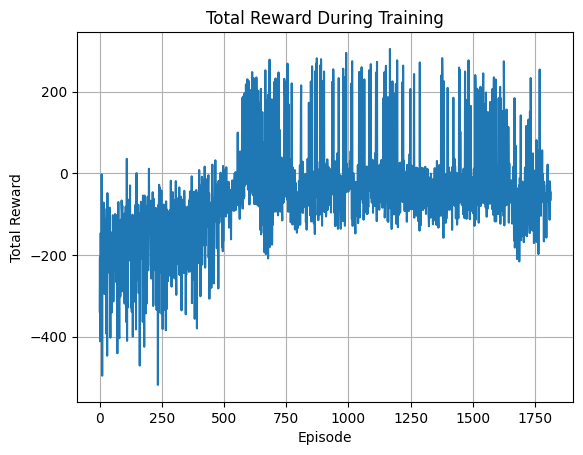

In [39]:
import pandas as pd

monitor_file = os.path.join(log_dir, "monitor.csv")
df = pd.read_csv(monitor_file, skiprows=1)  # First row is a comment

# Plot reward over episodes
plt.plot(df["r"])  # 'r' is total reward
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward During Training")
plt.grid(True)
plt.show()

In [42]:
import time


# Load environment with rendering
base_env = gym.make("LunarLander-v3", render_mode="human")
env = DisturbedLunarLander(base_env, failure_prob=0.08, force_magnitude=20.0)
env = FuelAwareLunarLander(env, initial_fuel=100.0)


# Load trained model
model = DQN.load("dqn_lunarlander_f", env=env)

obs, _ = env.reset()  # <-- FIXED: unpack obs and info
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)  # New Gym returns 5 items
    if done or truncated:
        obs, _ = env.reset()
    time.sleep(0.02)

env.close()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 

C:\Users\dastu\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
C:\Users\dastu\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


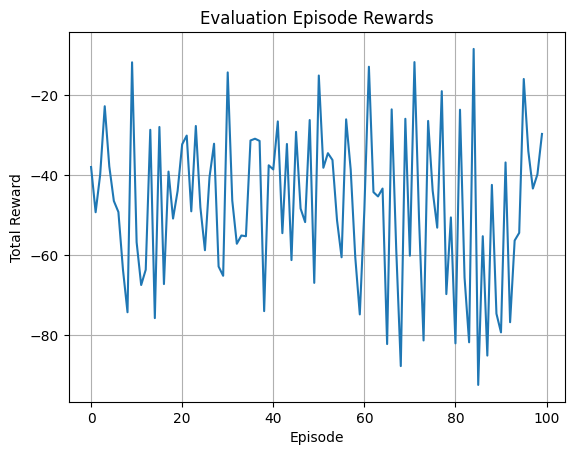

In [34]:
import matplotlib.pyplot as plt


# Create evaluation env with RecordEpisodeStatistics
base_env = gym.make("LunarLander-v3")
eval_env = FuelAwareLunarLander(base_env, initial_fuel=100.0)
eval_env = RecordEpisodeStatistics(eval_env)

# Load trained model
model = DQN.load("dqn_lunarlander_f", env=eval_env)

episode_rewards = []
n_eval_episodes = 100  # or more, depending on how detailed you want the plot

for _ in range(n_eval_episodes):
    obs, info = eval_env.reset()
    done, truncated = False, False
    total_reward = 0
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = eval_env.step(action)
        total_reward += reward
    episode_rewards.append(total_reward)

# Plotting
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Evaluation Episode Rewards")
plt.grid(True)
plt.show()





In [40]:
import gymnasium as gym
import numpy as np
import time
from stable_baselines3 import DQN

# Custom disturbance wrapper
class DisturbedLunarLander(gym.Wrapper):
    def __init__(self, env, failure_prob=0.05, force_magnitude=10.0):
        super().__init__(env)
        self.failure_prob = failure_prob
        self.force_magnitude = force_magnitude

        # Unwrap to access base LunarLander for physics manipulation
        base = env
        while hasattr(base, "env"):
            base = base.env
        self.base_env = base

    def step(self, action):
        disturbance_triggered = False
        force_applied = (0, 0)

        # Random engine failure
        if np.random.rand() < self.failure_prob:
            action = 0  # Disable engine
            print("[!] Engine failure simulated!")
            disturbance_triggered = True

        obs, reward, terminated, truncated, info = self.env.step(action)

        # Random horizontal force
        if np.random.rand() < self.failure_prob:
            force_applied = (np.random.uniform(-self.force_magnitude, self.force_magnitude), 0)
            try:
                self.base_env.lander.ApplyForceToCenter(force_applied, True)
                print(f"[!] Random force applied to lander: {force_applied}")
                disturbance_triggered = True
            except AttributeError:
                print("[!] Warning: Lander not initialized yet")

        if disturbance_triggered:
            info["disturbed"] = True
            info["force"] = force_applied

        return obs, reward, terminated, truncated, info

# Create disturbed environment
base_env = gym.make("LunarLander-v3", render_mode="human")
env = DisturbedLunarLander(base_env, failure_prob=0.08, force_magnitude=20.0)
env = FuelAwareLunarLander(env, initial_fuel=100.0)
model = DQN.load("dqn_lunarlander_f", env=env)

obs, _ = env.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    time.sleep(0.02)


# Load trained model
model = DQN.load("dqn_lunarlander_f", env=env)

# Reset environment
obs, _ = env.reset()
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    # Optional: Highlight disturbances in the console
    if info.get("disturbed", False):
        print(f"[*] Disturbance handled | Force: {info['force']}")

    time.sleep(0.02)

    if done or truncated:
        print(">>> Episode finished. Resetting environment...\n")
        obs, _ = env.reset()
        #done = False

env.close()


C:\Users\dastu\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
C:\Users\dastu\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[!] Engine failure simulated!
[!] Random force applied to lander: (-9.31791938588535, 0)
[!] Engine failure simulated!
[!] Engine failure simulated!
[!] Random force applied to lander: (1.758077460515711, 0)
[!] Engine failure simulated!
[!] Engine failure simulated!
[!] Random force applied to lander: (-4.45106812295052, 0)
[!] Random force applied to lander: (-14.442847152874773, 0)
[!] Random force applied to lander: (5.178450010157594, 0)
[!] Engine failure simulated!
[!] Random force applied to lander: (-0.8209062177259412, 0)
[!] Engine failure simulated!
[!] Random force applied to lander: (16.006065508117658, 0)
[!] Engine failure simulated!
[!] Random force applied to lander: (14.499467565342592, 0)
[!] Random force applied to lander: (0.603685965643507, 0)
[!] Engine failure simulated!
[!] Engine failure simulated!
[!] Engine failure simulated!
[!] Engine failure simulated!
[!] Engine failure simulat

KeyboardInterrupt: 